# MÁSTER DATA SCIENCE, BIG DATA & BUSINESS ANALYTICS 2024-2025  
## BASE DE DATOS NoSQL  
### PROF. Alvaro Bravo | ALUMNO: Marcio Yassuhiro Iha

### 1. INTRODUCTION  

About Spotify (https://investors.spotify.com/about/default.aspx)  
- The world’s most popular audio streaming subscription service
- More than 678 million users, including 268 million subscribers
- More than 180 markets
- More than 100,000,000 tracks / songs in 2023  

A dataset of the most streamed songs on Spotify was selected. Despite containing 953 tracks, it will be referred to as the ***TOP 1000 Most Streamed Songs in 2023*** for greater impact.

The goal is to analyze the artists and key song characteristics of Spotify's TOP 1000 streamed songs of 2023 to extract meaningful insights.

Comments about the coding part:
1) This is part of NoSQL DATABASE course at the Máster of Data Science, Big Data & Business Analytics at Universidad Complutense de Madrid
2) I used the ***pymongo*** library - the official Python driver for MongoDB
3) My code is basically split in two parts: (a) the QUERIES will be based in ***pymongo*** commands, and (b) the CHARTS and TABLE VIEWS will be done with python's ***matplotlib*** and other common libraries.

### 2. DATABASE AND DATA MODEL  

Dataset: Most Streamed Spotify Songs 2023 - https://www.kaggle.com/datasets/nelgiriyewithana/top-spotify-songs-2023/data  
Author: Nidula Elgiriyewithana - https://www.kaggle.com/nelgiriyewithana  
Number of docs: 953 songs but to simplify communication I will call this list 'TOP 1000 MOST STREAMED SONGS 2023'  

The original dataset was preserved, including its exact column names, such as the typo 'speechiness'.

We start by analyzing the dataset. It has 953 rows with 24 columns, divided in three groups:
#### Artist and Track info
**- track_name**: (String) Name of the track (song).  
**- artist(s)_name**: (String/Array) Name(s) of the artist(s) who performed the track.  
**- artist_count**: (Integer) The number of artists credited for the track.  
**- released_year**: (Integer) The year the track was released.  
**- released_month**: (Integer) The month the track was released (1-12).  
**- released_day**: (Integer) The day of the month the track was released (1-31).  
#### Audio Features  
**- bpm**: (Integer/Float) Beats Per Minute. The overall estimated tempo of a track.  
**- key**: (String/Integer) The key the track is in. Integers map to pitches (e.g., 0 = C, 1 = C#/Db). Can be blank or -1 if not detected.  
**- mode**: (String) Indicates the modality (major or minor) of a track. Typically "Major" or "Minor".  
**- danceability_%**: (Integer) How suitable a track is for dancing, expressed as a percentage (0-100). Based on tempo, rhythm stability, beat strength, etc.  
**- valence_%**: (Integer) Musical positiveness conveyed by a track, as a percentage (0-100). High valence = more positive (happy, cheerful).  
**- energy_%**: (Integer) Perceptual measure of intensity and activity, as a percentage (0-100). Energetic tracks feel fast, loud, and noisy.  
**- acousticness_%**: (Integer) Confidence measure of whether the track is acoustic, as a percentage (0-100). 100% = high confidence.  
**- instrumentalness_%**: (Integer) Predicts whether a track contains no vocals, as a percentage (0-100). High value = greater likelihood of no vocal content.  
**- liveness_%**: (Integer) Detects the presence of an audience in the recording, as a percentage (0-100). Higher values = increased probability the track was performed live.  
**- speechiness_%**: (Integer) Detects the presence of spoken words in a track, as a percentage (0-100). Higher values = more speech-like content.
#### Platform metrics  
**- in_spotify_playlists**: (Integer) The number of Spotify playlists the track is included in.  
**- in_spotify_charts**: (Integer) The number of times the track has appeared in Spotify charts, or its current chart position (depends on dataset specifics).  
**- streams**: (Integer/String) The total number of streams the track has on Spotify (Note: 'streams' data in public datasets might be from a specific source or not officially from Spotify directly for all tracks).  
**- in_apple_playlists**: (Integer) The number of Apple Music playlists the track is included in.  
**- in_apple_charts**: (Integer) The number of times the track has appeared in Apple Music charts, or its current chart position.
**- in_deezer_playlists**: (Integer/String) The number of Deezer playlists the track is included in.  
**- in_deezer_charts**: (Integer) The number of times the track has appeared in Deezer charts, or its current chart position.  
**- in_shazam_charts**: (Integer/String) The number of times the track has appeared in Shazam charts, or its current chart position/count of Shazams.    

### 3. CODES, QUERIES and ANALYSIS  

#### 3.1. Extract, Transform and Load (ETL)  

In [43]:
# Importing libraries
from pymongo import MongoClient
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import islice

In the analysis of the dataset we notice some relevant **IMPORTING ERRORS:**  
**Problem:** Encoding issues during import resulted in corrupted strings (e.g., '??????' in artist_name). Attempts to import with various encodings ('utf-8', 'latin1', 'ISO-8859-2', 'ISO-8859-1') were unsuccessful, a known problem with this dataset. Inspection of the original 'spotify_2023_UTF8.csv' file revealed 40 affected cells in the artist_name column.  
**Action:** Given the importance of artist_name column for the analysis, the data was cleaned externally using a spreadsheet (Excel) and a Spotify account for verification. This process identified and corrected 40 entries in this column. Consequently, the revised dataset "spotify_2023_UTF8_artist_clean.csv" will be used for all subsequent analysis.

Converting the .csv file to JSON:

In [44]:
conversion = pd.read_csv("spotify_2023_UTF8_artist_clean.csv", sep=",", header=0)
conversion.to_json("clases.spotify2023_clean.json", orient="records", indent=4, force_ascii=False)

Connecting to client (MongoDB), db (clases) to a new collection (spotify2023_cleaned):

In [45]:
# Connecting to MongoDB with a new collection: spotify2023_cleaned
client = MongoClient('mongodb://localhost:27017/')
db = client['clases']
collection = db['spotify2023_cleaned']

Opening the cleaned JSON file created and showing the variable names:

In [46]:
with open('clases.spotify2023_clean.json', 'r', encoding='UTF-8') as file: 
    data = json.load(file)

# Inserting cleaned data
collection.delete_many({})  # Clearing existing data, if there is any
collection.insert_many(data)

# Getting distinct field names
variable_names = collection.find_one().keys()
print("Variable Names:", variable_names)

Variable Names: dict_keys(['_id', 'track_name', 'artist_name', 'artist_count', 'released_year', 'released_month', 'released_day', 'in_spotify_playlists', 'in_spotify_charts', 'streams', 'in_apple_playlists', 'in_apple_charts', 'in_deezer_playlists', 'in_deezer_charts', 'in_shazam_charts', 'bpm', 'key', 'mode', 'danceability_%', 'valence_%', 'energy_%', 'acousticness_%', 'instrumentalness_%', 'liveness_%', 'speechiness_%'])


Excluding the PLATFORM METRICS columns and other columns that I will not use in this analysis:

In [47]:
collection.update_many({}, { '$unset': {
                                'artist_count': "",
                                'in_spotify_playlists': "",
                                'released_month': "",
                                'released_day': "",
                                'in_spotify_charts': "",
                                'in_apple_playlists': "",
                                'in_apple_charts': "",
                                'in_deezer_playlists': "",
                                'in_deezer_charts': "",
                                'in_shazam_charts': ""
                        }}
                      ) 

variable_names = collection.find_one().keys()
print("Variable Names:", variable_names)         

Variable Names: dict_keys(['_id', 'track_name', 'artist_name', 'released_year', 'streams', 'bpm', 'key', 'mode', 'danceability_%', 'valence_%', 'energy_%', 'acousticness_%', 'instrumentalness_%', 'liveness_%', 'speechiness_%'])


Visualizing the dataset in TABLE VIEW, using a pandas Data Frame, to facilitate the data inspection:

In [48]:
# Defining the fields to filter out
fields_to_exclude = {
    'artist_count': 0,
    'in_spotify_playlists': 0,
    'released_month': 0,
    'released_day': 0,
    'in_spotify_charts': 0,
    'in_apple_playlists': 0,
    'in_apple_charts': 0,
    'in_deezer_playlists': 0,
    'in_deezer_charts': 0,
    'in_shazam_charts': 0
}

# Using aggregation to sort and project
pipeline1 = [
    {"$sort": {"streams": -1}},
    {"$project": fields_to_exclude}
]

# VIEWING IN TABLE VIEW - Loading data into a list called 'df_print'
data = list(collection.aggregate(pipeline1))
# Creating a pandas Data Frame
df_print = pd.DataFrame(data)
# Displaying the DataFrame in TABLE VIEW to facilitate visualization - Last 5 documents
df_print

,_id,track_name,artist_name,released_year,streams,bpm,key,mode,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%
0,683848f93d8ecd0164af6013,Blinding Lights,The Weeknd,2019,3.703895e+09,171,C#,Major,50,38,80,0,0,9,7
1,683848f93d8ecd0164af6014,Shape of You,Ed Sheeran,2017,3.562544e+09,96,C#,Minor,83,93,65,58,0,9,8
2,683848f93d8ecd0164af6015,Someone You Loved,Lewis Capaldi,2018,2.887242e+09,110,C#,Major,50,45,41,75,0,11,3
3,683848f93d8ecd0164af6016,Dance Monkey,Tones and I,2019,2.864792e+09,98,F#,Minor,82,54,59,69,0,18,10
4,683848f93d8ecd0164af6017,Sunflower - Spider-Man: Into the Spider-Verse,"Post Malone, Swae Lee",2018,2.808097e+09,90,D,Major,76,91,50,54,0,7,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
948,683848f93d8ecd0164af63c7,"Gol Bolinha, Gol Quadrado 2","Mc Pedrinho, DJ 900",2023,1.195664e+07,133,B,Minor,93,68,65,42,0,12,25
949,683848f93d8ecd0164af63c8,QUEMA,"Sog, Ryan Castro, Peso Pluma",2023,1.159939e+07,97,None,Major,79,92,89,5,0,6,5
950,683848f93d8ecd0164af63c9,Jhoome Jo Pathaan,"Arijit Singh, Vishal Dadlani, Sukriti Kakar, V...",2022,1.365184e+06,105,G,Major,82,62,74,10,0,33,7
951,683848f93d8ecd0164af63ca,Que Vuelvas,"Carin Leon, Grupo Frontera",2022,2.762000e+03,162,A#,Major,49,78,64,19,0,11,4


In the TABLE VIEW we can notice some issues with the number of 'streams' because there is a Nan (None) and the other last two tracks have a number of streams too small for a TOP 1000 worldwide rank, let's investigate some numeric columns stats:

In [49]:
# STATS FOR THE KEY NUMERICAL COLUMNS STREAMS, BPM, RELEASE_YEAR (no AUDIO FEATURES columnns)

# Defining the aggregation pipeline
pipeline2 = [
    {
        "$group": {
            "_id": None,  # Group all documents together
            "count_streams": {"$sum": 1},
            "avg_streams": {"$avg": "$streams"},
            "min_streams": {"$min": "$streams"},
            "max_streams": {"$max": "$streams"},
            "count_bpm": {"$sum": 1},
            "avg_bpm": {"$avg": "$bpm"},
            "min_bpm": {"$min": "$bpm"},
            "max_bpm": {"$max": "$bpm"},
            "count_year": {"$sum": 1},
            "avg_year": {"$avg": "$released_year"},
            "min_year": {"$min": "$released_year"},
            "max_year": {"$max": "$released_year"}
        }
    }
]

# Executing the aggregation pipeline
results2 = list(collection.aggregate(pipeline2))

# Printing the results
if results2:
    stats = results2[0]  # The aggregation returns a list with one document
    print("Statistics:")
    print(f"  Streams: Count={stats['count_streams']}, Avg={stats['avg_streams']}, Min={stats['min_streams']}, Max={stats['max_streams']}")
    print(f"  BPM: Count={stats['count_bpm']}, Avg={stats['avg_bpm']}, Min={stats['min_bpm']}, Max={stats['max_bpm']}")
    print(f"  Release Year: Count={stats['count_year']}, Avg={stats['avg_year']}, Min={stats['min_year']}, Max={stats['max_year']}")
else:
    print("No data found in the collection.")

Statistics:
  Streams: Count=953, Avg=514137424.93907565, Min=2762.0, Max=3703895074.0
  BPM: Count=953, Avg=122.54039874081847, Min=65, Max=206
  Release Year: Count=953, Avg=2018.2381951731375, Min=1930, Max=2023


Streams is our most important numerical variable in this analysis. We can confirm that the minimum value for 'streams' (2762) is problematic. Reviewing the preceding TABLE VIEW, it's evident that the last three songs listed have inadequate 'streams' values, therefore we can proceed to remove them from our dataset.

**DATA CLEANING 1: TREATING OUTLIERS / ERRORS IN THE NUMBER OF STREAMS:**  
**Problem:** The final three rows in the Table Visualization exhibit anomalous 'streams' values: a 'NaN' and two entries with orders of magnitude significantly lower than the preceding data.  
**Action:** Remove 3 documents (outliers) from the dataset.  

First, we should find how many None are there in the 'streams' column, and eliminate them:

In [50]:
clean_nan = collection.delete_many({ "streams": None }) # NaN is not defined, so I tried 'None' instead
print(f"Documentos deletados: {clean_nan.deleted_count}")

Documentos deletados: 1


Deleting the 2 least streamed songs with outlier 'streams':

In [51]:
# Finding the _id of the 2 documents to be deleted
pipeline3 = [
    {"$sort": {"streams": 1}}, 
    {"$limit": 2 },
    {"$project": { "_id": 1 } }  
]

results3 = list(collection.aggregate(pipeline3))
print(f"Documents to find for deletion: {results3}")

# Extracting the _id values from the list of dictionaries
ids_to_delete = [doc['_id'] for doc in results3 if '_id' in doc]
print(f"IDs to delete: {ids_to_delete}")

if ids_to_delete:
    # Creating a query to delete documents with these _ids
    delete_query = {"_id": {"$in": ids_to_delete}}

    # Execute the delete operation
    docs_deleted = collection.delete_many(delete_query)
    print(f"Documents deleted: {docs_deleted.deleted_count}")
else:
    print("No documents found to delete based on the aggregation.")

# VIEWING IN TABLE VIEW 
# Loading data into a list called 'df_print'
data = list(collection.find())
# Creating a pandas Data Frame
df_print = pd.DataFrame(data)
# Displaying the DataFrame in TABLE VIEW to facilitate visualization - Last 5 documents
df_print.tail(5)

Documents to find for deletion: [{'_id': ObjectId('683848f93d8ecd0164af63ca')}, {'_id': ObjectId('683848f93d8ecd0164af63c9')}]
IDs to delete: [ObjectId('683848f93d8ecd0164af63ca'), ObjectId('683848f93d8ecd0164af63c9')]
Documents deleted: 2


,_id,track_name,artist_name,released_year,streams,bpm,key,mode,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%
945,683848f93d8ecd0164af63c4,Rush,Troye Sivan,2023,22581161.0,126,F,Minor,74,35,84,0,0,11,6
946,683848f93d8ecd0164af63c5,S91,Karol G,2023,16011326.0,128,None,Minor,86,42,72,59,0,9,19
947,683848f93d8ecd0164af63c6,Overdrive,Post Malone,2023,14780425.0,140,C#,Major,56,48,73,0,0,35,4
948,683848f93d8ecd0164af63c7,"Gol Bolinha, Gol Quadrado 2","Mc Pedrinho, DJ 900",2023,11956641.0,133,B,Minor,93,68,65,42,0,12,25
949,683848f93d8ecd0164af63c8,QUEMA,"Sog, Ryan Castro, Peso Pluma",2023,11599388.0,97,None,Major,79,92,89,5,0,6,5


We can confirm with this TABLE VIEW that the songs 950, 951 and 952 were deleted from the collection!  

Next we should also take a look to the type 'object' column KEY:

In [52]:
# Analyzing the tracks by song KEY
# Defining the aggregation pipeline for grouping by KEY
pipeline4 = [
    {
        "$group": {
            "_id": "$key",
            "count": { "$sum": 1 }
        }
    },
    {
        "$sort": { "_id": 1 }
    }
]

# Executing the aggregation for KEY groups
results4 = collection.aggregate(pipeline4)

#printing ("Track count by KEY group:")
for group in results4:
    print(group)

{'_id': None, 'count': 95}
{'_id': 'A', 'count': 74}
{'_id': 'A#', 'count': 56}
{'_id': 'B', 'count': 81}
{'_id': 'C#', 'count': 120}
{'_id': 'D', 'count': 81}
{'_id': 'D#', 'count': 33}
{'_id': 'E', 'count': 62}
{'_id': 'F', 'count': 89}
{'_id': 'F#', 'count': 73}
{'_id': 'G', 'count': 95}
{'_id': 'G#', 'count': 91}


**DATA CLEANING 2: INCONSISTENT DATA IN COLUMN KEY:**  
**Problem:** The 'key' column contains 'None', mainly because key of C = 0 in Spotify's coding.  
**Action:** Replace 'None' for 'C'

In [53]:
# Updating documents where 'key' is 'None'
update_result = collection.update_many(
    {'key': {'$in': ['None', None]}},  # Filter for documents where 'key' is the 'None'
    {'$set': {'key': 'C'}}  # Set the 'key' field to the string 'C'
)

print(f"Updated {update_result.modified_count} documents where 'key' was 'None' and was set to the key of 'C'.")

Updated 95 documents where 'key' was 'None' and was set to the key of 'C'.


Now that we have cleaned our database, let's proceed to analyze it.

#### 3.2. ANALYZING THE ARTISTS THAT MADE TO THE TOP 1000

##### 3.2.1. CONSOLIDATED NUMBER OF 'STREAMS' BY 'ARTIST_NAME'  
Stream counts by artist (unmodified artist_name column | without collaborations).

In [54]:
# Aggregation pipeline
pipeline_5 = [
    {
        "$group": {
            "_id": "$artist_name",
            "track_count": {"$sum": 1},
            "total_streams": {"$sum": "$streams"}
        }
    },
    {
        "$sort": {"total_streams": -1}
    }
]

# Executing the aggregation pipeline
results5 = list(collection.aggregate(pipeline_5))

# Displaying the first 5 lines of the results
for document in islice(results5, 5):
    print(json.dumps(document, indent=4, ensure_ascii=False))

# Printing total number of UNIQUE artist_names
print(f"Total number of ARTISTS (without collaborations): {len(results5)}")

{
    "_id": "The Weeknd",
    "track_count": 22,
    "total_streams": 14185552870.0
}
{
    "_id": "Taylor Swift",
    "track_count": 34,
    "total_streams": 14053658300.0
}
{
    "_id": "Ed Sheeran",
    "track_count": 9,
    "total_streams": 13908947204.0
}
{
    "_id": "Harry Styles",
    "track_count": 17,
    "total_streams": 11608645649.0
}
{
    "_id": "Bad Bunny",
    "track_count": 19,
    "total_streams": 9997799607.0
}
Total number of ARTISTS (without collaborations): 642


##### 3.2.2. CONSOLIDATED NUMBER OF 'STREAMS' ALSO CONSIDERING COLLABORATIONS WITH OTHER 'ARTIST_NAME'  
Solo and collaborative track counts per artist (within the Top 1000).

In [55]:
# Aggregation pipeline
pipeline6 = [
    {
        "$project": {
            "_id": 1,
            "artist_name": 1,
            "streams": 1,
            "artists": { "$split": ["$artist_name", ", "] }
        }
    },
    {
        "$unwind": "$artists"
    },
    {
        "$group": {
            "_id": "$artists",
            "trackCount": { "$sum": 1 },
            "totalStreams": { "$sum": "$streams" }
        }
    },
    {
        "$sort": { "totalStreams": -1 }
    }
]

# Executing the aggregation pipeline and converting to list
results6 = list(collection.aggregate(pipeline6))

# Displaying the first 5 lines of the results
for result in islice(results6, 4):
    print(json.dumps(result, indent=4, ensure_ascii=False))

# Printing total number of unique artists
print(f"Total number of ARTISTS (considering collaborations): {len(results6)}")

{
    "_id": "Bad Bunny",
    "trackCount": 41,
    "totalStreams": 24947393058.0
}
{
    "_id": "The Weeknd",
    "trackCount": 37,
    "totalStreams": 23929760757.0
}
{
    "_id": "Ed Sheeran",
    "trackCount": 14,
    "totalStreams": 15316587718.0
}
{
    "_id": "Taylor Swift",
    "trackCount": 38,
    "totalStreams": 14630378183.0
}
Total number of ARTISTS (considering collaborations): 691


##### 3.2.3. ARTIST STREAM LEVERAGE THROUGH COLLABORATIONS: [SOLO] vs. [SOLO+COLLABORATIVE TRACKS]

**ANALYSIS:** In 2023's SPOTIFY TOP 1000, the top solo artists by streams were The Weeknd (14.1B, 22 songs), Taylor Swift (14.0B, 34 songs), and Ed Sheeran (13.9B, 9 songs). However, collaborations significantly boost total streams for many artists.

Bad Bunny exemplifies this: his streams increase from 10B (solo) to 25B (including collaborations), elevating him from 3rd to 1st, with his top 1000 song count rising from 19 to 41. The Weeknd, Dua Lipa, Drake, and Eminem also demonstrate successful collaboration strategies.

In the graph below we can see how artists expand their audience by collaborating with others. The red dotted line (the 1:1 line) represents artists who entered the top 1000 without any collaborations. Thus, the further above the 1:1 line an artist is positioned, the greater the increase in streams attributable to collaborations.

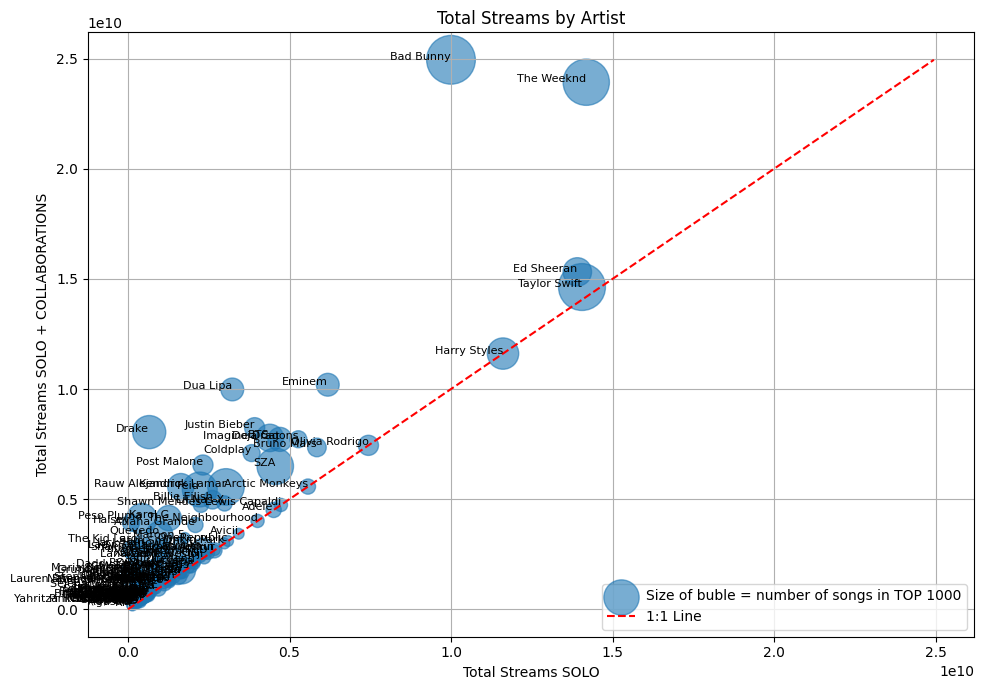

In [56]:
# Converting the results5 to a DataFrame
df1 = pd.DataFrame(results5)
df1.rename(columns={'track_count': 'trackCount', 'total_streams': 'totalStreams'}, inplace=True)

# Converting the results6 to a DataFrame
df2 = pd.DataFrame(results6)

# Merging DataFrames on artist name
merged_df = pd.merge(df1, df2, on='_id', suffixes=('_pipeline5', '_pipeline6'))

# Filtering artists with more than one song
filtered_df = merged_df[merged_df['trackCount_pipeline6'] > 1]

# Plotting
plt.figure(figsize=(10, 7))

# Scatter plot
scatter = plt.scatter(
    filtered_df['totalStreams_pipeline5'],
    filtered_df['totalStreams_pipeline6'],
    s=filtered_df['trackCount_pipeline6'] * 30,  # Bubble size
    alpha=0.6,
    label='Size of buble = number of songs in TOP 1000'
)

# Add artist names
for i, row in filtered_df.iterrows():
    plt.text(
        row['totalStreams_pipeline5'],
        row['totalStreams_pipeline6'],
        row['_id'],
        fontsize=8,
        ha='right'
    )

# Diagonal line for 1:1 relationship
max_value = max(filtered_df['totalStreams_pipeline5'].max(), filtered_df['totalStreams_pipeline6'].max())
plt.plot([0, max_value], [0, max_value], color='red', linestyle='--', label='1:1 Line')

# Labels and title
plt.xlabel('Total Streams SOLO')
plt.ylabel('Total Streams SOLO + COLLABORATIONS')
plt.title('Total Streams by Artist')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### 3.3. ANALYZING THE SONGS THAT MADE TO THE TOP 1000  

##### 3.3.1 STREAM COUNT PER TRACK  

In [57]:
# Defining the projection
pipeline7 = {
    "_id": 0,
    "track_name": 1,
    "streams": 1
}

# Executing the query with the projection
results7 = list(collection.find({}, pipeline7).sort("streams", -1))

# Printing the top element in the dataset
print("TOP element in the dataset:")
for result in islice(results7, 1):
    print(json.dumps(result, indent=4, ensure_ascii=False))

# Printing the last element in the dataset
print("\nLAST element the dataset:")
for result in islice(results7, len(results7) - 1, len(results7)):
    print(json.dumps(result, indent=4, ensure_ascii=False))

if len(results7) > 1:
    top_streams = results7[0]['streams']
    last_streams = results7[-1]['streams']
    
    if last_streams != 0:  # Avoid division by zero
        division_result = top_streams / last_streams
        print(f"TOP number of streams is {division_result} times bigger than the LAST ")
    else:
        print("The last element has zero views, division not possible.")
else:
    print("Not enough documents to perform the operation.")

TOP element in the dataset:
{
    "track_name": "Blinding Lights",
    "streams": 3703895074.0
}

LAST element the dataset:
{
    "track_name": "QUEMA",
    "streams": 11599388.0
}
TOP number of streams is 319.3181462677169 times bigger than the LAST 


**ANALYSIS:** There is an enormous concentration of streams in the top streamed tracks, with volume decreasing sharply towards the long tail. In the TOP 1000 ranking, the most popular song was played over 319 more times than the lowest-ranked song.  
This behaviour becomes clear in the bar chart below:

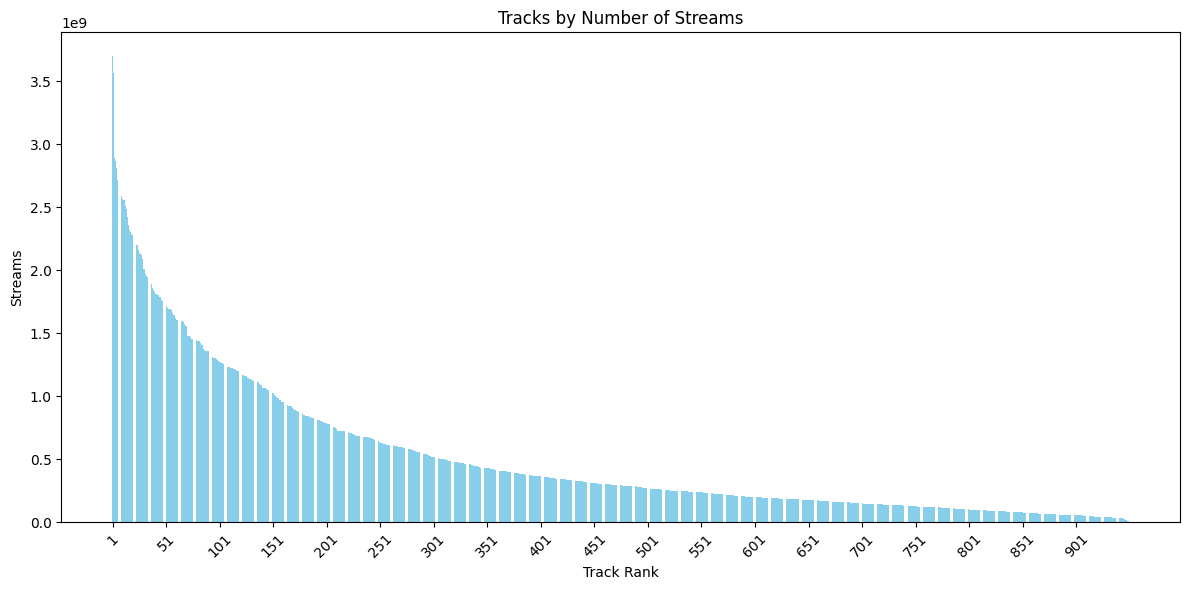

In [58]:
# BAR CHART
# Projection query
pipeline8 = {
    "_id": 0,
    "track_name": 1,
    "streams": 1
}

# Executing the query with the projection and sort by streams in descending order
results8 = collection.find({}, pipeline8).sort("streams", -1)

# Preparing data for the bar chart
streams = []

# Extracting all results
for result in results8:
    # Replace None with 0 for streams
    streams.append(result['streams'] if result['streams'] is not None else 0)

# Creating indices for the x-axis
indices = list(range(1, len(streams) + 1))

# Creating the bar chart
plt.figure(figsize=(12, 6))
plt.bar(indices, streams, color='skyblue')
plt.xlabel('Track Rank')
plt.ylabel('Streams')
plt.title('Tracks by Number of Streams')

# Setting x-ticks to show every 50th index, starting from 1
plt.xticks(range(1, len(indices) + 1, 50), rotation=45, ha='center')
plt.tight_layout()

# Showing the plot
plt.show()

##### 3.3.2. TRACKS CATEGORIZED BY BPM (beats per minute)  

In [59]:
# Analyzing the tracks by BPM
# Defining the aggregation pipeline for grouping tracks by BPM ranges
pipeline9 = [
    {
        "$bucket": {
            "groupBy": "$bpm",
            "boundaries": [0, 60, 90, 120, 150, 180, 210],
            "default": "210+",
            "output": {
                "trackCount": { "$sum": 1 }
            }
        }
    }
]

# Executing the aggregation to get track counts by BPM ranges
results9 = collection.aggregate(pipeline9)
print("Track count by BPM range:")
for bpm_range in results9:
    print(bpm_range)

# Defining the aggregation pipeline for calculating BPM statistics
pipeline10 = [
    {
        "$group": {
            "_id": None,
            "averageBPM": { "$avg": "$bpm" },
            "bpmStandardDeviation": { "$stdDevPop": "$bpm" },
            "minBPM": { "$min": "$bpm" },
            "maxBPM": { "$max": "$bpm" },
            "count": { "$sum": 1 }           
        }
    }
]

# Executing the aggregation to get BPM statistics
bpm_statistics_results = collection.aggregate(pipeline10)
bpm_statistics = next(bpm_statistics_results, {})

# Extracting statistics
average_bpm = bpm_statistics.get('averageBPM', 0)
min_bpm = bpm_statistics.get('minBPM', 'N/A')
max_bpm = bpm_statistics.get('maxBPM', 'N/A')
count = bpm_statistics.get('count', 0)

# Printing the BPM statistics
print(f"BPM Mean: {average_bpm}")
print(f"BPM Standard Deviation: {bpm_statistics.get('bpmStandardDeviation', 'N/A')}")
print(f"BPM Min: {min_bpm}")
print(f"BPM Max: {max_bpm}")
print(f"Total Tracks: {count}")

Track count by BPM range:
{'_id': 60, 'trackCount': 98}
{'_id': 90, 'trackCount': 337}
{'_id': 120, 'trackCount': 353}
{'_id': 150, 'trackCount': 133}
{'_id': 180, 'trackCount': 29}
BPM Mean: 122.53052631578947
BPM Standard Deviation: 28.049404060408214
BPM Min: 65
BPM Max: 206
Total Tracks: 950


**ANALYSIS:** The average BPM for the TOP 100 Spotify tracks is 122, ranging from 65 to 206. The box plot indicates that 50% of these tracks fall between 100 and 140 BPM, with three outliers exceeding the upper interquartile range limit of 200 BPM.

Average Beats per Minute in the TOP 100 Spotify tracks is 122 bpm, in a range that starts in 65 and goes up to 206 bpm. In the BOX PLOT graphic below we can see that 50% of tracks are between 100 and 140 bpms, and that there are a few outliers above 200 bpms, the interquartile range upper limit.  

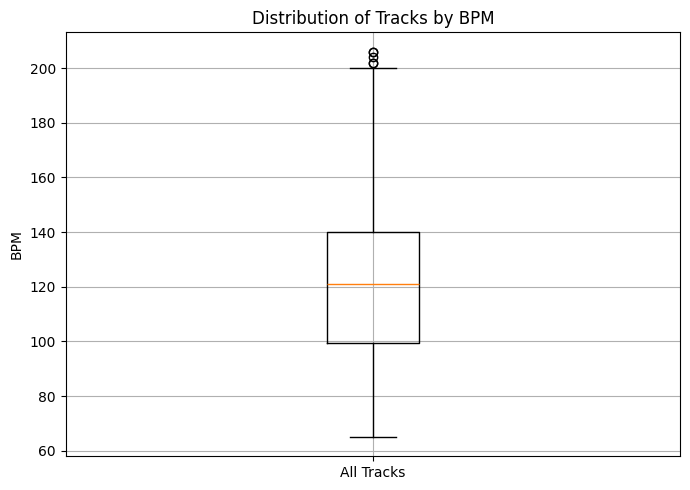

In [60]:
# BOX PLOT CHART
# Re-running the aggregation to get all BPM values
pipeline10 = [
    {
        "$group": {
            "_id": None,
            "all_bpms": {"$push": "$bpm"}
        }
    }
]

results10 = list(collection.aggregate(pipeline10))
all_bpms = results10[0]['all_bpms'] if results10 else []

# --- Generating the Box Plot ---
if all_bpms:
    plt.figure(figsize=(7, 5))
    plt.boxplot(all_bpms)
    plt.title('Distribution of Tracks by BPM')
    plt.ylabel('BPM')
    plt.xticks([1], ['All Tracks'])  # Label for the single box plot
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("No BPM data available to create a box plot.")

##### 3.3.3. TRACKS BY KEY   

{'_id': 'A', 'count': 74}
{'_id': 'A#', 'count': 56}
{'_id': 'B', 'count': 81}
{'_id': 'C', 'count': 95}
{'_id': 'C#', 'count': 120}
{'_id': 'D', 'count': 81}
{'_id': 'D#', 'count': 33}
{'_id': 'E', 'count': 62}
{'_id': 'F', 'count': 89}
{'_id': 'F#', 'count': 73}
{'_id': 'G', 'count': 95}
{'_id': 'G#', 'count': 91}


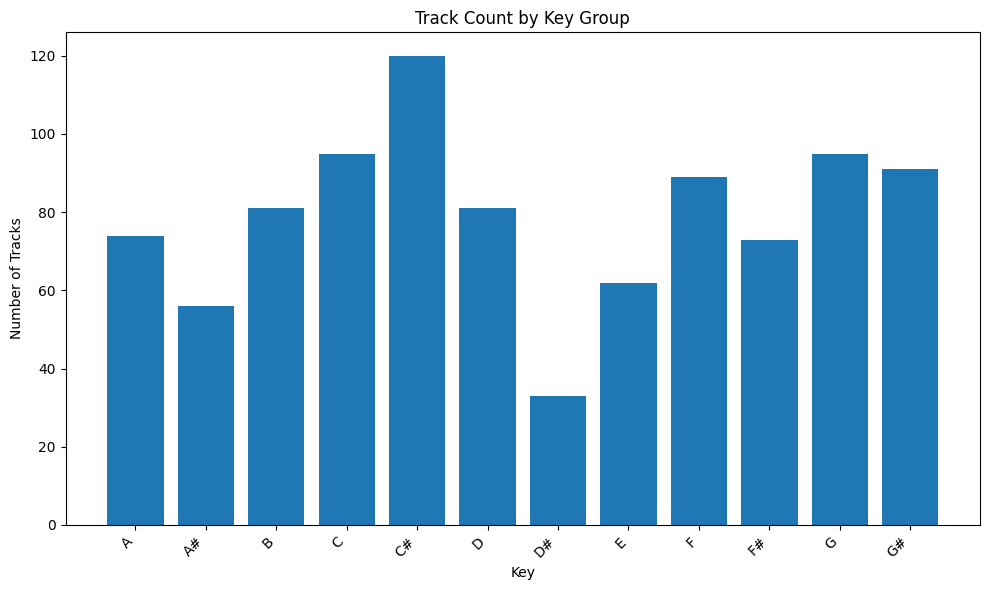

In [61]:
# Analyzing the tracks by song KEY
# Defining the aggregation pipeline for grouping by KEY
pipeline11 = [
    {
        "$group": {
            "_id": "$key",
            "count": { "$sum": 1 }
        }
    },
    {
        "$sort": { "_id": 1 }
    }
]

# Executing the aggregation for KEY groups
key_groups = collection.aggregate(pipeline11)

#printing ("Track count by KEY group:")
for group in key_groups:
    print(group)

# BAR CHART - Converting the cursor to list to generate a chart
key_groups2 = list(collection.aggregate(pipeline11))  

# Preparing the data for plotting
keys = [group["_id"] for group in key_groups2]
counts = [group["count"] for group in key_groups2]

# Creating the bar chart
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.bar(keys, counts)
plt.xlabel("Key")
plt.ylabel("Number of Tracks")
plt.title("Track Count by Key Group")
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping

# Showing the chart
plt.show()

**ANALYSIS:** While an evaluation of tracks by key is potentially insightful even after we replaced 'None' by 'C' the resulting distribution showed a mode in C#, a very unusual key in pop music. Consequently, this key-based analysis was deemed unreliable and excluded from further consideration.

##### 3.3.4. TRACKS CATEGORIZED BY MUSICAL SCALE MODE (major or minor)  

**ANALYSIS:** Major scale tracks, typically associated with happier and more uplifting sounds, constituted 58% of the TOP 1000 Spotify tracks in 2023. Minor scale tracks, often perceived as sad or mysterious, accounted for the remaining 42%. This analysis reveals a relatively balanced distribution between the two musical scale modes within the top tracks.

In [62]:
# Analyzing the tracks by song MODE (major or minor)
# Defining the aggregation pipeline for grouping by MODE
mode_group_pipeline = [
    {
        "$group": {
            "_id": "$mode",
            "count": { "$sum": 1 }
        }
    },
    {
        "$sort": { "_id": 1 }
    }
]

# Executing the aggregation for MODE groups
mode_groups = collection.aggregate(mode_group_pipeline)

# Printing the track count by MODE group
print("Track count by MODE group:")
for group in mode_groups:
    print(f"Mode: {group['_id']}, Count: {group['count']}")

Track count by MODE group:
Mode: Major, Count: 547
Mode: Minor, Count: 403


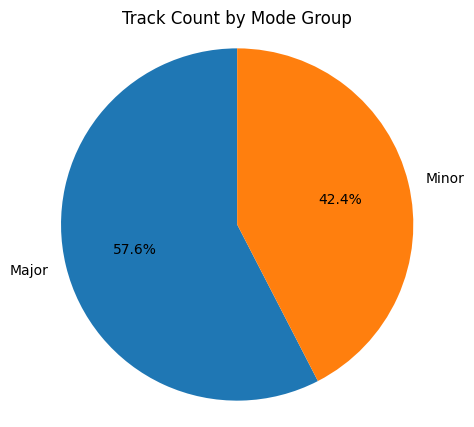

In [63]:
# PIE CHART
# Executing the aggregation
mode_groups = collection.aggregate(mode_group_pipeline)

# Preparing data for plotting
modes = []
counts = []

for group in mode_groups:
    mode = group['_id']  # Directly use the string value
    modes.append(mode)
    counts.append(group['count'])

# Creating the pie chart
plt.figure(figsize=(5, 5))
plt.pie(counts, labels=modes, autopct='%1.1f%%', startangle=90)
plt.title('Track Count by Mode Group')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Show the plot
plt.show()

##### 3.3.5. TRACKS BY RELEASE YEAR

**ANALYSIS:** The 2023 data suggests a typical one-year trajectory for Spotify success, evidenced by the high performance of tracks released in 2022 (400 songs). However, new releases from 2023 already show strong traction (around 175 tracks), likely benefiting from novelty, early adoption by trendsetters, and increased promotional activity.

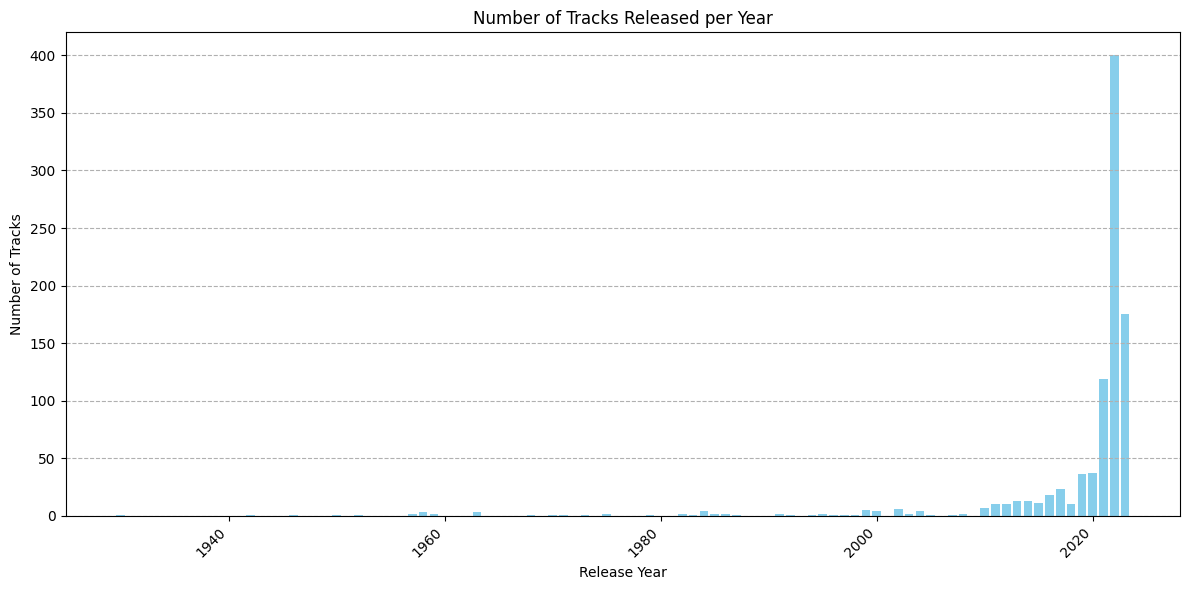


Bar Chart Key Parameters:
  Earliest Year: 1930
  Latest Year: 2023
  Total Tracks Analyzed: 950
  Year with Most Releases: 2022 (400 tracks)


In [64]:
# BAR CHART FOR SONGS BY YEAR OF RELEASE
# Defining the aggregation pipeline 
pipeline12 = [
    {
        "$match": {
            "released_year": { "$ne": None }
        }
    },
    {
        "$group": {
            "_id": "$released_year",
            "trackCount": { "$sum": 1 }
        }
    },
    {
        "$sort": { "_id": 1 }  # Sort by year in ascending order for the bar chart
    }
]

# Executing the aggregation
results12 = list(collection.aggregate(pipeline12))

# Extracting data for the bar chart
years = [item['_id'] for item in results12]
track_counts = [item['trackCount'] for item in results12]

# --- Creating the Bar Chart ---
plt.figure(figsize=(12, 6))  # Adjust figure size as needed
plt.bar(years, track_counts, color='skyblue')
plt.xlabel('Release Year')
plt.ylabel('Number of Tracks')
plt.title('Number of Tracks Released per Year')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.grid(axis='y', linestyle='--')
plt.show()

# Printing Key Parameters (informative)
if results12:
    total_tracks = sum(track_counts)
    earliest_year = min(years)
    latest_year = max(years)
    peak_year_index = track_counts.index(max(track_counts))
    peak_year = years[peak_year_index]
    peak_track_count = track_counts[peak_year_index]

    print("\nBar Chart Key Parameters:")
    print(f"  Earliest Year: {earliest_year}")
    print(f"  Latest Year: {latest_year}")
    print(f"  Total Tracks Analyzed: {total_tracks}")
    print(f"  Year with Most Releases: {peak_year} ({peak_track_count} tracks)")
else:
    print("\nNo data available to generate the bar chart or its parameters.")

##### 3.3.6. AUDIO FEATURES ANALYSIS

Spotify's **audio feature** information refers to a set of parameters that describe various musical qualities of a song - Please refer to section 2. DATABASE AND DATA MODEL for more details.  
Spotify analyzes each track in its library and assigns values to these features, providing a quantitative way to understand the sonic characteristics of the music. We will use  the information from this section in the CONCLUSION.

In [65]:
# CAlCULATING THE AVERAGE AND THE MODE FOR EACH AUDIO FEATURE ATTRIBUTE

attributes = [
    'danceability_%', 'valence_%', 'energy_%',
    'acousticness_%', 'instrumentalness_%',
    'liveness_%', 'speechiness_%'
]

calculated_stats = {} # Dictionary to save the mean and the mode for each attribute

for attribute in attributes:
    # Calculate Median using aggregation
    mean_pipeline = [
    {
        "$group": {
            "_id": None,
            "average": { "$avg": f"${attribute}" }
        }
    }
    ]

    mean_result = list(collection.aggregate(mean_pipeline))
    mean_value = mean_result[0]['average'] if mean_result else None

    # Calculate Mode using aggregation
    mode_pipeline = [
        {"$group": {"_id": f"${attribute}", "count": {"$sum": 1}}},
        {"$sort": {"count": -1, "_id": 1}},
        {"$limit": 1},
        {"$project": {"_id": 0, "mode": "$_id"}}
    ]
    mode_result = list(collection.aggregate(mode_pipeline))
    mode_value = mode_result[0]['mode'] if mode_result else None

    calculated_stats[attribute] = {'mean': round(mean_value), 'mode': mode_value}

# Print the calculated median and mode for each attribute
print("Calculated_stats for each ATTRIBUTE:")
for attribute, stats in calculated_stats.items():
    print(f"{attribute}: Median = {stats['mean']}, Mode = {stats['mode']}")

Calculated_stats for each ATTRIBUTE:
danceability_%: Median = 67, Mode = 70
valence_%: Median = 51, Mode = 24
energy_%: Median = 64, Mode = 62
acousticness_%: Median = 27, Mode = 0
instrumentalness_%: Median = 2, Mode = 0
liveness_%: Median = 18, Mode = 11
speechiness_%: Median = 10, Mode = 4


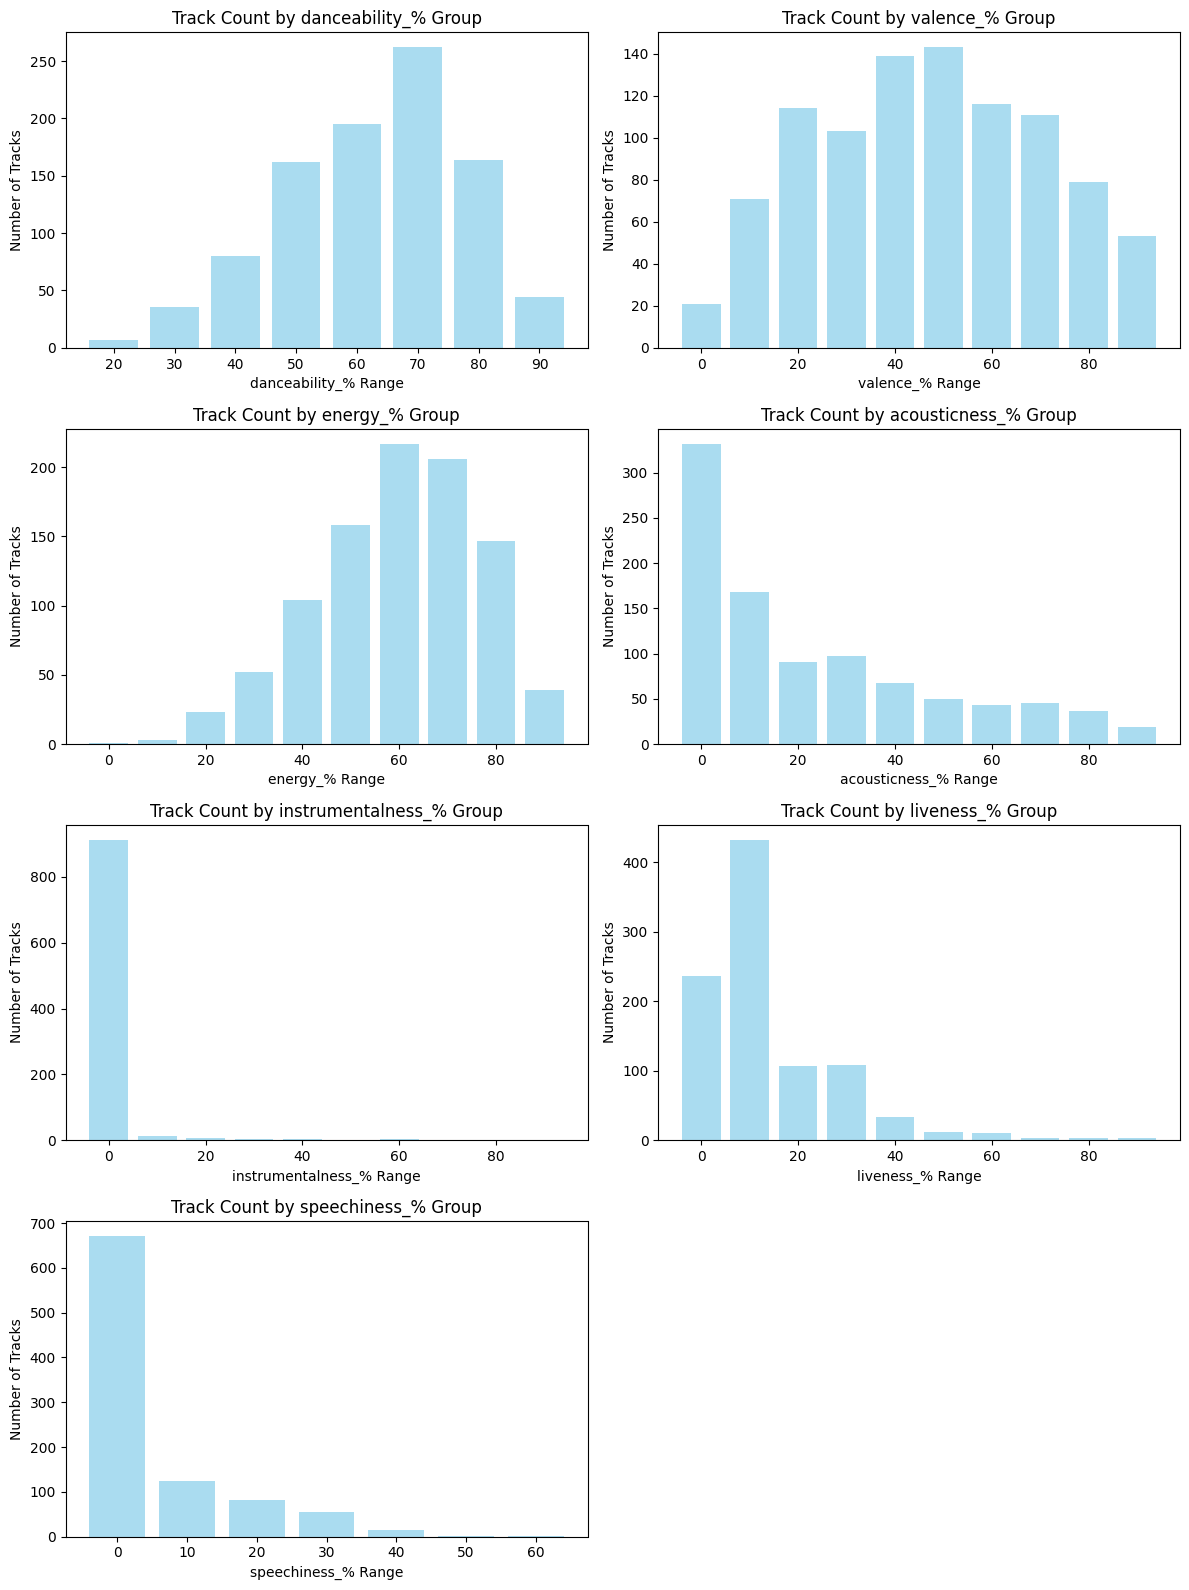

In [66]:
# DASHBOARD OF HISTOGRAMS FOR AUDIO FEATURES VARIABLES

# Using the variable 'attributes' defined in the previous code

# Creating a dashboard with 7 histograms
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(12, 16))
axes = axes.flatten()

for i, variable in enumerate(attributes):
    pipeline = [
        {
            "$bucket": {
                "groupBy": f"${variable}",
                "boundaries": [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
                "default": "Other",
                "output": {
                    "count": { "$sum": 1 }
                }
            }
        }
    ]

    # Execute the aggregation for each variable
    result = list(collection.aggregate(pipeline))

    # Extract ranges and counts
    ranges = [group['_id'] for group in result if group['_id'] != "Other"]
    counts = [group['count'] for group in result if group['_id'] != "Other"]

    # Convert ranges to strings for labeling
    range_labels = [f"{r}-{r+10}" for r in ranges]
    
    # Plot the histogram
    axes[i].bar(ranges, counts, width=8, color='skyblue', alpha=0.7, align='center')
    axes[i].set_title(f'Track Count by {variable} Group')
    axes[i].set_xlabel(f'{variable} Range')
    axes[i].set_ylabel('Number of Tracks')

# Removing the empty subplot
fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()


### 4. CONCLUSIONS - KEY CHARACTERISTICS OF THE TRACKS

#### 4.1. TYPICAL AUDIOFEATURES IN THE TOP 1000

In this part I play with the idea of showing how each of the typical AUDIO FEATURES in the TOP 1000 rank sounds like.  
By taking the mean of the variable distribution when 'normal' shaped distributions (Danceability, Valence, Energy) and the mode for very assymetric ones (Acousticness, Instrumentalness, Liveness, Speechiness) - Please refer to section 2. DATABASE AND DATA MODEL for more details.  
I ran a code to do it but wiht the previous calculations I could do specific queries to come up with the typical song for each variable. 

In [67]:
# TYPICAL AUDIO FEATURE ATTRIBUTES SONGS IN THE TOP 1000

attribute_metrics = {
    'danceability_%': 'mean',
    'valence_%': 'mean',
    'energy_%': 'mean',
    'acousticness_%': 'mode',
    'instrumentalness_%': 'mode',
    'liveness_%': 'mode',
    'speechiness_%': 'mode'
}

# calculated_stats created in item "3.3.6. AUDIO FEATURES ANALYSIS"

# Generate optimized_stats dynamically
optimized_stats = {
    attr: calculated_stats[attr][stat_type] 
    for attr, stat_type in attribute_metrics.items()
}

# Query MongoDB and get results
results = []
for attribute, target_value in optimized_stats.items():
    top_track = collection.find(
        {attribute: target_value},
        {'track_name': 1, 'artist_name': 1, 'streams': 1, attribute: 1, '_id': 0}
    ).sort({ 'streams': -1 }).limit(1)
    
    for track in top_track:
        results.append({
            'attribute': attribute,
            #'metric': stat_type,
            'metric_value': target_value,
            #'track_metric': track[attribute],
            'track_name': track['track_name'],
            'artist_name': track['artist_name'],
            'streams': track['streams']
        })

pd.DataFrame(results)

,attribute,metric_value,track_name,artist_name,streams
0,danceability_%,67,Night Changes,One Direction,1.131091e+09
1,valence_%,51,Die For You,The Weeknd,1.647990e+09
2,energy_%,64,Where Are You Now,"Lost Frequencies, Calum Scott",9.725096e+08
3,acousticness_%,0,Blinding Lights,The Weeknd,3.703895e+09
4,instrumentalness_%,0,Blinding Lights,The Weeknd,3.703895e+09
5,liveness_%,11,Someone You Loved,Lewis Capaldi,2.887242e+09
6,speechiness_%,4,Something Just Like This,"The Chainsmokers, Coldplay",2.204081e+09


If you want to hear what each of these typical Audio Features in the TOP 1000 Spotify songs of 2023, be my guest:

- Night Changes by One-direction - https://youtu.be/syFZfO_wfMQ?si=kRt-jC3Qd1dewdmf
- Die for you by The Weeknd - https://youtu.be/uPD0QOGTmMI?si=HdlDnn8x2sub1H3Q
- Where are you by Lost Frequencies and Calum Scott - https://youtu.be/PoP2Sa7wYNQ?si=LM1Tn7LL_CywYcAA  
- Blinding Lights by The Weeknd - https://youtu.be/4NRXx6U8ABQ?si=0AxFmBRpucKYWB1o
- Someone You Loved by Lewis Capaldi - https://youtu.be/zABLecsR5UE?si=zTwnuSIIfPq8X7Me  
- Something Just Like This by The Chainsmokers, Coldplay - https://youtu.be/FM7MFYoylVs?si=d8_qPiWoAEJv07Pb  

#### 4.2 AUDIO FEATURE ANALYSIS OF THE TOP 5 TRACKS  

While I admire the visual appeal of Spider Charts, their parametrization remains complex for me. Therefore, I utilized Google Gemini Flash 2.5 for the subsequent coding. This resulted in suboptimal efficiency and flow, including the creation of redundant data entities like the 'audio_features' (here) and 'attributes' (earlier) lists. However, for the sake of this grand finale, I request permission to proceed with this visually compelling Spider Chart.

MongoDB Query Executed.
Retrieved 5 documents from MongoDB.
Data structured for plotting.


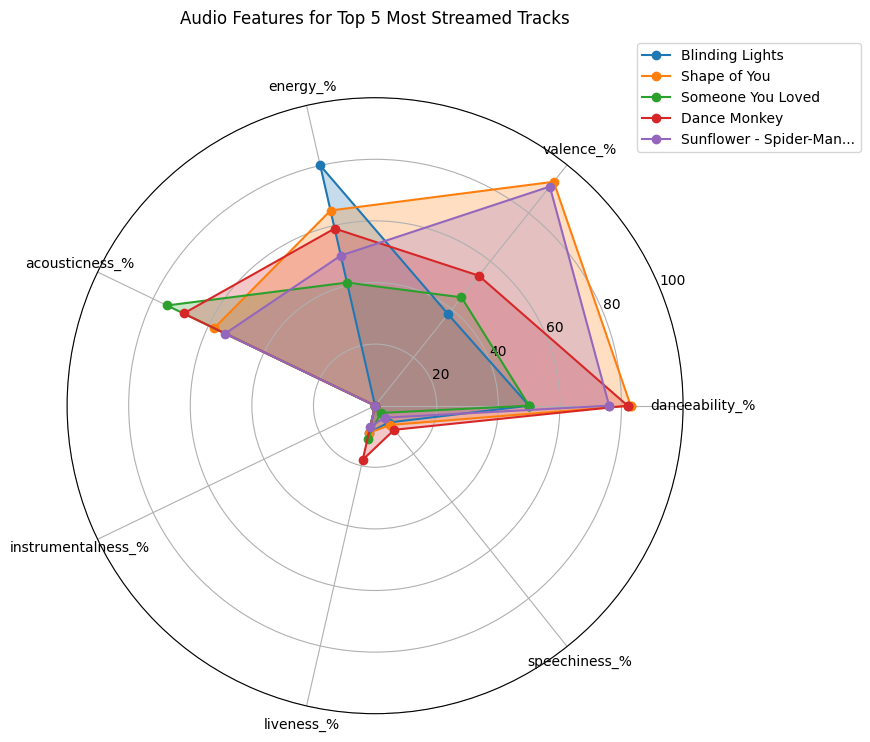

In [68]:
# SPIDER CHART WITH AUDIO FEATURES (by Gemini 2.5 Flash)

try:
    projection_fields = {
        "Track_Name": "$track_name",
        "Artist_Name": "$artist_name",
        "Streams": "$streams", 
        "danceability_%": 1,
        "valence_%": 1,
        "energy_%": 1,
        "acousticness_%": 1,
        "instrumentalness_%": 1,
        "liveness_%": 1,
        "speechiness_%": 1,
        "_id": 0 
    }
   
    # Sorting by the *original* field name 'streams' in descending order (-1) and limit to 5
    top_tracks_cursor = collection.find(
        {}, # Empty filter to get all documents (you might need a specific filter)
        projection_fields
    ).sort("streams", -1).limit(5) 

    print("MongoDB Query Executed.") # Add a print to confirm query runs
    # Converting the cursor result to a list of dictionaries
    top_tracks_list = list(top_tracks_cursor)
    print(f"Retrieved {len(top_tracks_list)} documents from MongoDB.") # Print count
    
    if top_tracks_list: # Check if the list is not empty before processing
        data_for_plotting_from_mongo = {
            key: [doc.get(key) for doc in top_tracks_list]
            for key in projection_fields.keys() if key != "_id"
        }
        print("Data structured for plotting.")
    else:
        data_for_plotting_from_mongo = {}
        print("No data retrieved from MongoDB.")

except Exception as e:
    print(f"An error occurred during MongoDB query: {e}")
    # Setting to empty dictionary if query fails, so DataFrame creation doesn't error
    data_for_plotting_from_mongo = {}
    top_tracks_list = [] # Also clear the list

# Converting the data to a pandas DataFrame
# If data_for_plotting_from_mongo is empty, this will be an empty DataFrame
df_cleaned = pd.DataFrame(data_for_plotting_from_mongo)

# Defining the audio feature columns using the requested English names
audio_features = ['danceability_%', 'valence_%', 'energy_%', 'acousticness_%', 'instrumentalness_%', 'liveness_%', 'speechiness_%']

# Defining the labels for the radar chart axes
categories = audio_features

# Number of variables
N = len(categories)

# Calculating angle for each category
angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1] # Complete the loop for plotting

# Create a single polar plot figure and axis
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

# Looping through each track and plot its data on the same axis
# Checking if the DataFrame is not empty before looping
if not df_cleaned.empty:
    for index, row in df_cleaned.iterrows():
        # Safely get track name, default to None if missing
        track_name = row.get('Track_Name')

        # Get the audio feature values for the current track
        # Use .get() with a default value (e.g., 0) for features to handle potential None/missing values
        values = [row.get(feature, 0) for feature in audio_features]
        values += values[:1] # Complete the loop for plotting

        # Plot data for the current track
        line, = ax.plot(angles, values, linestyle='solid', marker='o')

        # Fill area for the current track
        ax.fill(angles, values, alpha=0.25)

        # Create a legend label (handle None track_name)
        # Convert to string to ensure len() works
        legend_label = str(track_name) if track_name is not None else "Unknown Track"
        if len(legend_label) > 25: # Now len() is safe as legend_label is a string
            legend_label = legend_label[:22] + '...'

        # Add a handle for the legend
        line.set_label(legend_label)

    # Setting axis limits and labels
    ax.set_ylim(0, 100) # Assuming features are percentages up to 100
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories)

    # Setting title for the overall chart
    ax.set_title("Audio Features for Top 5 Most Streamed Tracks", va='bottom', y=1.1) # Adjust y position for title

    # Adding a legend outside the plot area
    # Adjust bbox_to_anchor to position the legend cleanly
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

    # Displaying the plot
    plt.show()
else:
    print("Cannot generate chart")

client.close()

**ANALYSIS:** This Spider Chart reveals distinct characteristics among the top 5 most-streamed songs of 2023. Notably, SPEECHINESS, LIVELINESS, and INSTRUMENTALNESS are NOT prominent features in these tracks.

Each of the top 5 songs demonstrates an outstanding presence in at least one of the other 4 Audio Features. "Blinding Lights" exhibits high **ENERGY**. "Shape of You" and "Sunflower" both score highly in **VALENCE** and **DANCEABILITY**, while "Someone You Loved" has the highest **ACOUSTICNESS**. "Dance Monkey" also shows strong **DANCEABILITY**.  

These observations may offer clues to the attributes contributing to a song's success in reaching the top.

Explore the top 5 songs below and form your own conclusions:

-Blinding Lights by The Weeknd - https://youtu.be/4NRXx6U8ABQ?si=0AxFmBRpucKYWB1o  
-Shape of You by Ed Sheeran - https://youtu.be/JGwWNGJdvx8?si=6xQM7atTi5tktseq  
-Someone You Loved by Lewis Capaldi - https://youtu.be/zABLecsR5UE?si=zTwnuSIIfPq8X7Me  
-Starboy by The Weeknd, Daft Punk - https://youtu.be/34Na4j8AVgA?si=xmXpBbP4fayNdCNF  
-Dance Monkey by Tones and I - https://youtu.be/q0hyYWKXF0Q?si=kN9xikGQsS35qoxT  
-Sunflower - Spider-Man: Into the Spider-Verse  - https://youtu.be/ApXoWvfEYVU?si=qYIp-1Jk0c8Zy9Jq  

Thank you!